In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.express as px
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.offline as pyo
from plotly.subplots import make_subplots

import squarify 

### Questions:  
-How users are distributed over countries?  
-How many outliers are there in data (in terms of deposits)?  
-Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones  
-Visualize deposits distribution over sources and channels  
-What are your advices to marketing team in order to optimize their activity?

In [2]:
data_path = r'C:\Users\okruz\Downloads\synthetic_data.csv'
country_path = r'C:\Users\okruz\Downloads\countries.csv'

In [3]:
df = pd.read_csv(data_path).drop(['Unnamed: 0'],axis=1)
country_df = pd.read_csv(country_path)
df.head(5)

,depo,segment,channel,clicks,latency,client_id
0,0,postid_4057,smm,1.0,2.649725,1442498
1,0,telegram,affiliate,10.0,2.610846,7865631
2,0,postid_8542,facebook,13.0,3.001162,8165584
3,0,telegram,direct,0.0,1.788369,5893056
4,0,telegram,smm,0.0,1.932069,3780924


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219314 entries, 0 to 219313
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   depo       219314 non-null  int64  
 1   segment    219314 non-null  object 
 2   channel    217142 non-null  object 
 3   clicks     219314 non-null  float64
 4   latency    219314 non-null  float64
 5   client_id  219314 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 10.0+ MB


In [5]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219314 entries, 0 to 219313
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   country    219314 non-null  object
 1   client_id  219314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ MB


In [6]:
df = pd.merge(df,country_df)

In [7]:
df.duplicated().sum()

61754

In [8]:
df.drop_duplicates(inplace=True, ignore_index=True, keep='first')

In [9]:
df.isna().sum()

depo            0
segment         0
channel      1598
clicks          0
latency         0
client_id       0
country         0
dtype: int64

In [10]:
for cat_colname in df.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df[cat_colname].value_counts(dropna=False)) + '\n' + '*' * 100 + '\n')

segment

telegram       44401
postid_1673       28
postid_6236       28
postid_1997       26
postid_1513       25
               ...  
postid_1911        2
postid_7675        2
postid_302         2
postid_4504        2
postid_450         2
Name: segment, Length: 9801, dtype: int64
****************************************************************************************************

channel

facebook        55029
smm             47359
social media    30137
direct          15625
affiliate        7812
NaN              1598
Name: channel, dtype: int64
****************************************************************************************************

country

DE    14504
ES    14443
US    14427
IS    14407
VN    14374
LT    14341
FR    14292
MO    14226
IN    14215
IT    14211
LU    14120
Name: country, dtype: int64
****************************************************************************************************



In [11]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [12]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 8.41 MB
Memory usage after optimization is: 3.03 MB
Decreased by 64.0%


In [13]:
df["client"] = df["depo"].apply(lambda x:True if x > 0 else False)

In [14]:
df["segment"] = df["segment"].apply(lambda x:'telegram' if x == 'telegram' else 'article')

In [15]:
df.client.value_counts(normalize=True)

False    0.954386
True     0.045614
Name: client, dtype: float64

In [16]:
df.channel.value_counts(dropna=False)

facebook        55029
smm             47359
social media    30137
direct          15625
affiliate        7812
NaN              1598
Name: channel, dtype: int64

In [17]:
df['channel'] = df['channel'].cat.add_categories(['unknown'])
df['channel'].fillna('unknown', inplace=True)
df.channel.value_counts(dropna=False)

facebook        55029
smm             47359
social media    30137
direct          15625
affiliate        7812
unknown          1598
Name: channel, dtype: int64

### How users are distributed over countries?  

In [18]:
df.country.value_counts(normalize=True)

DE    0.092054
ES    0.091667
US    0.091565
IS    0.091438
VN    0.091229
LT    0.091019
FR    0.090708
MO    0.090289
IN    0.090220
IT    0.090194
LU    0.089617
Name: country, dtype: float64

In [19]:
countries = df['country'].value_counts()
countries = pd.DataFrame(countries)
countries = countries.reset_index()
countries.columns = ['country', 'users']

In [20]:
colors = ['MediumPurple',] * 12
colors[0] = 'darkviolet'

fig = px.bar(countries, x='users', y='country', text_auto=True, hover_name='country')
fig.update_traces(marker_color=colors, opacity=0.8, textfont=dict(size=12, color='white'))

fig.update_layout(font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Distribution of users over country'},
          plot_bgcolor='white', xaxis={'showgrid': False}, yaxis={'showgrid':False},  hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"))

fig.update_xaxes(range=[10000, 15000])
fig.update_xaxes(spikecolor="black", spikesnap="data", spikemode="across", spikethickness=1)
                  
fig.show()

In [21]:
df.query('client == True').country.value_counts()

IS    687
DE    677
IN    672
VN    667
ES    659
US    657
LT    646
IT    643
LU    641
FR    623
MO    615
Name: country, dtype: int64

In [22]:
client_country = df.query('client == True')['country'].value_counts()
client_country = pd.DataFrame(client_country)
client_country = client_country.reset_index()
client_country.columns = ['country', 'clients']

In [23]:
fig = px.bar(client_country, x='clients', y='country', text_auto=True, hover_name='country')
fig.update_traces(marker_color=colors, opacity=0.8, textfont=dict(size=12, color='white'))

fig.update_layout(font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Distribution of clients over country'},
          plot_bgcolor='white', xaxis={'showgrid': False}, yaxis={'showgrid':False},  hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"))

fig.update_xaxes(spikecolor="black", spikesnap="data", spikemode="across", spikethickness=1)
fig.show()

In [24]:
countries = df.pivot_table(['depo', 'client'], 
['country'], aggfunc='mean').sort_values(by='depo', ascending=False).reset_index()
countries['client']=countries['client']*100
countries = countries.round(2)
countries = countries.rename(columns={"client": "conversion, %"})
countries

,country,"conversion, %",depo
0,ES,4.56,26.04
1,DE,4.67,25.56
2,LT,4.50,23.55
3,MO,4.32,23.36
4,IS,4.77,22.25
5,IN,4.73,21.91
6,VN,4.64,21.83
7,US,4.55,21.39
8,LU,4.54,20.42
9,IT,4.52,20.25


*Users and clients across countries are **evenly distributed**. Conversion rate is also about the same for all countries, but mean deposit is different*

### How many outliers are there in data (in terms of deposits)?  

In [25]:
depo_df = df.query('client == True').reset_index()
depo_df['depo'].describe()

count     7187.000000
mean       487.145262
std       1772.385130
min          1.000000
25%        214.000000
50%        322.000000
75%        429.000000
max      29527.000000
Name: depo, dtype: float64

In [26]:
std = depo_df['depo'].std()
mean = depo_df['depo'].mean()
((depo_df['depo'] < (mean - 3 * std)) | (depo_df['depo'] > (mean + 3 * std))).sum()

69

In [27]:
Q1 = depo_df['depo'].quantile(0.25)
Q3 = depo_df['depo'].quantile(0.75)
IQR = Q3 - Q1
((depo_df['depo'] < (Q1 - 1.5 * IQR)) | (depo_df['depo'] > (Q3 + 1.5 * IQR))).sum()

78

In [28]:
fig = go.Figure()
fig = px.box(depo_df, x="depo", log_x=True, points="all")
fig.update_traces(marker_color='MediumPurple')
fig.update_layout(font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Box plot of deposits'},
          plot_bgcolor='white',
          xaxis={'title': 'deposit'},
          hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)
fig.add_vline(x=mean + 3 * std, line_width=2, opacity=0.5, line_dash="dash", line_color="MediumPurple")
fig.add_annotation(text=r'$3\sigma$', showarrow=False, y = 0.5, x = 3.7)
fig.add_vrect(x0=mean + 3 * std, x1=50000, line_width=0, fillcolor="MediumPurple", opacity=0.1)

fig.show()

In [29]:
negative_balance = df.query('depo < 0').pivot_table(['depo'], 
['segment'], aggfunc='count').reset_index()
negative_balance

,segment,depo
0,article,2
1,telegram,68


In [30]:
negative_balance_sum = df.query('depo < 0').pivot_table(['depo'], 
['segment'], aggfunc='sum').reset_index()
negative_balance_sum

,segment,depo
0,article,-20
1,telegram,-2089


**78 outliers** *in terms of deposits, according to the **box-plot** analysis*  
**69 outliers** *in terms of deposits, according to the **z-score** analysis with $3\sigma$ (99.7% of the data)*

*There are also **70** users with negative deposit:**68** from telegram segment and **2** from article segment*

### Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones  

In [31]:
segments = df.pivot_table(['depo', 'client'], 
['segment'], aggfunc='mean').reset_index()
segments['client']=segments['client']*100
segments = segments.round(2)
segments = segments.rename(columns={"client": "conversion, %"})
segments

,segment,"conversion, %",depo
0,article,3.86,21.91
1,telegram,6.35,22.98


In [32]:
fig = go.Figure(
    data=[
        go.Bar(
            name="Deposit mean",
            x=segments["segment"],
            y=segments['depo'],
            marker_color='MediumPurple',
            opacity=0.8,
            text=segments['depo']
        ),
        go.Bar(
            name="Conversion, %",
            x=segments["segment"],
            y=segments['conversion, %'],
            marker_color='dark salmon',
            opacity=0.8,
            text=segments['conversion, %']
        ),
    ],
 )

fig.update_layout(
          width=800,
          font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Deposit mean and conversion rate for different segments'},
          plot_bgcolor='white',
          hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)
fig.update_traces(textposition = 'inside', textfont=dict(size=14, color='white'))
                  
                  
fig.show()

In [33]:
segments_median = df.query('client == True').pivot_table(['depo'], 
['segment'], aggfunc='median').reset_index()
segments_median

,segment,depo
0,article,398
1,telegram,205


In [34]:
fig = px.bar(segments_median, x='depo', y='segment', height=300, text=segments_median['segment'],
             color="segment", color_discrete_sequence=['MediumPurple', 'dark salmon'], opacity=0.8)

fig.update_layout(showlegend=False,
          xaxis={'title': 'deposit median'},
          font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Client\'s deposits median over different segments'})

fig.update_layout(plot_bgcolor='white', xaxis={'showgrid': False}, yaxis={'showgrid':False},  hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="MS Sans Serif"
    ))

fig.update_traces(textposition = 'inside', insidetextanchor="start", textfont=dict(size=16, color='white'))
fig.update_yaxes(visible=False)

fig.show()

In [35]:
fig = go.Figure()
fig = px.box(df.query('client == True'), x="depo", y='segment', log_x=True, points="all",
             color="segment", color_discrete_sequence=['salmon', 'MediumPurple'])
fig.update_layout(showlegend=False, font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Box plot of client\'s deposits over different segments'},
          plot_bgcolor='white',
          xaxis={'title': 'deposit'},
          hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)

fig.show()

*Telegram has higher conversion rate - **6.35%** vs **3.86%** for articles.*  
*Mean deposit is about the same for client from telegram **22.98** and articles **21.91**.*  
*But median deposit for telegram client is about two times lower - **205** vs **398** for articles.*

*It's debatable which segment is better. Telegram has a higher conversion rate but lower median deposit.*

### Visualize deposits distribution over sources and channels  

In [36]:
segments_depo = df.pivot_table(['depo'], ['segment'], aggfunc='sum').reset_index()
segments_depo['depo'] = round((segments_depo['depo']/segments_depo['depo'].sum())*100, 2)
segments_depo.sort_values('depo', ascending=False)

,segment,depo
0,article,70.84
1,telegram,29.16


In [37]:
fig = px.pie(segments_depo, values='depo', names='segment', color_discrete_sequence=px.colors.sequential.Purp)

fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))

fig.update_layout(
          showlegend=False,
          font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'text': 'Percentage of the total deposit over segments'},
          hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)
fig.update_traces(textposition='inside', textinfo='percent+label', textfont=dict(size=16))


fig.show()

In [38]:
segments_clients = df.pivot_table(['client'], ['segment'], aggfunc='sum').reset_index()
segments_clients['client'] = round((segments_clients['client']/segments_clients['client'].sum())*100, 2)
segments_clients.sort_values('client', ascending=False)

,segment,client
0,article,60.79
1,telegram,39.21


In [39]:
fig = px.pie(segments_clients, values='client', names='segment', color_discrete_sequence=px.colors.sequential.Purp)

fig.update_traces(marker=dict(line=dict(color='#000000', width=1)))

fig.update_layout(
          showlegend=False,
          font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'text': 'Percentage of the total clients over segments'},
          hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)
fig.update_traces(textposition='inside', textinfo='percent+label',textfont=dict(size=16))

fig.show()

*Despite the fact that the percentage of clients from the article segment is **60.8%**, the percentage of their deposits is **70.8%**.  
Thereby, clients from the article segment make a larger deposit*

In [40]:
channels = df.pivot_table(['depo'], ['channel'], aggfunc='sum').reset_index()
channels['depo'] = round((channels['depo']/channels['depo'].sum())*100, 2)
channels.sort_values('depo', ascending=False)

,channel,depo
2,facebook,43.53
3,smm,34.08
1,direct,10.80
4,social media,7.37
0,affiliate,3.60
5,unknown,0.62


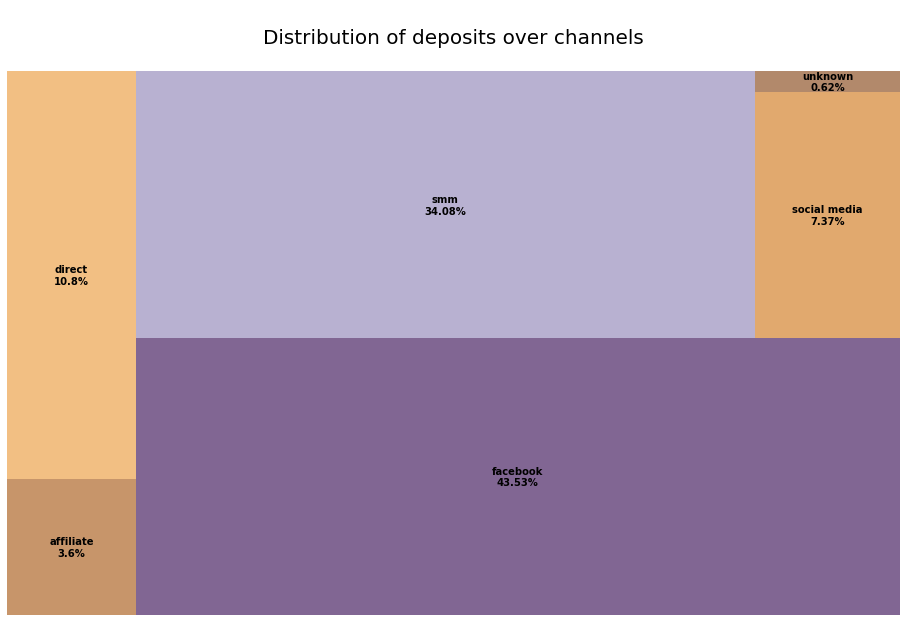

In [41]:
plt.figure(figsize=(16,10))
norm = matplotlib.colors.Normalize(vmin=min(channels.depo), vmax=max(channels.depo))
colors = [matplotlib.cm.PuOr(norm(value)) for value in channels.depo]
fig = plt.gcf()
labels = [f'{channel}\n{depo}%' for channel, depo in zip(channels.channel, channels.depo)]

squarify.plot(label=labels,sizes=channels.depo, color = colors, alpha=.6,
              text_kwargs={'fontsize':10, 'weight':'bold'})
plt.title("\nDistribution of deposits over channels\n",fontsize=20, fontfamily="sans-serif")

plt.grid(False)
plt.axis('off')
fig.patch.set_facecolor('white')
plt.show()

In [42]:
channels_clients = df.pivot_table(['client'], ['channel'], aggfunc='sum').reset_index()
channels_clients['client'] = round((channels_clients['client']/channels_clients['client'].sum())*100, 2)
channels_clients.sort_values('client', ascending=False)

,channel,client
2,facebook,40.04
3,smm,36.40
1,direct,9.68
4,social media,7.57
0,affiliate,5.37
5,unknown,0.93


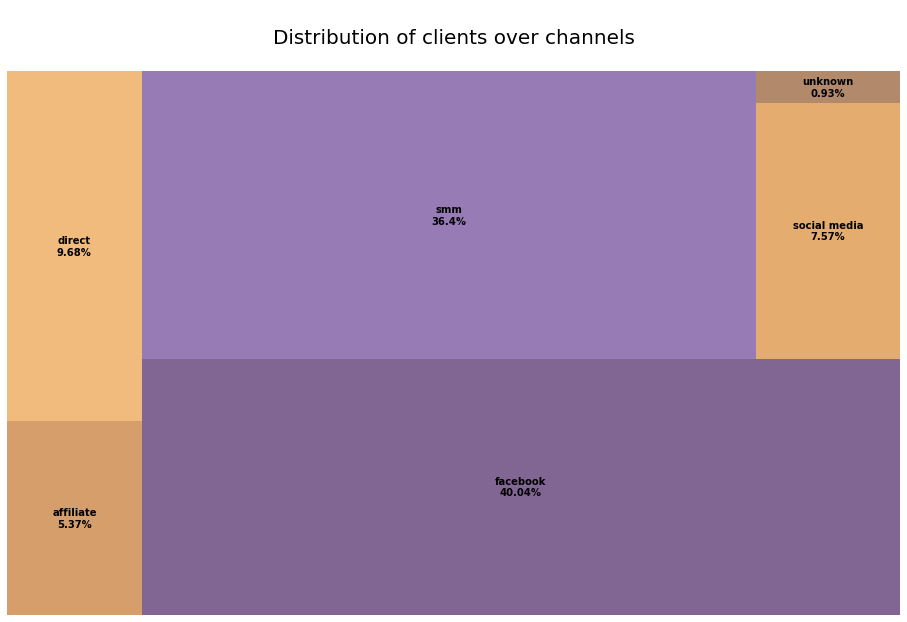

In [43]:
plt.figure(figsize=(16,10))
norm = matplotlib.colors.Normalize(vmin=min(channels_clients.client), vmax=max(channels_clients.client))
colors = [matplotlib.cm.PuOr(norm(value)) for value in channels_clients.client]
fig = plt.gcf()
labels = [f'{channel}\n{client}%' for channel, client in zip(channels_clients.channel, channels_clients.client)]

squarify.plot(label=labels,sizes=channels_clients.client, color = colors, alpha=.6,
              text_kwargs={'fontsize':10, 'weight':'bold'})
plt.title("\nDistribution of clients over channels\n",fontsize=20, fontfamily="sans-serif")

plt.grid(False)
plt.axis('off')
fig.patch.set_facecolor('white')
plt.show()

In [44]:
channels_mean = df.pivot_table(['depo', 'client'], 
['channel'], aggfunc='mean').reset_index()
channels_mean['client']=channels_mean['client']*100
channels_mean = channels_mean.round(2)
channels_mean = channels_mean.rename(columns={"client": "conversion, %"})

In [45]:
fig = go.Figure(
    data=[
        go.Bar(
            name="Deposit mean",
            y=channels_mean["channel"],
            x=channels_mean['depo'],
            marker_color='MediumPurple',
            opacity=0.8,
            text=channels_mean['depo']
        ),
        go.Bar(
            name="Conversion, %",
            y=channels_mean["channel"],
            x=channels_mean['conversion, %'],
            marker_color='dark salmon',
            opacity=0.8,
            text=channels_mean['conversion, %']
        ),
    ],
 )


fig.update_layout(yaxis={'categoryorder':'total descending'},
          font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Deposit mean and conversion rate over channels'},
          plot_bgcolor='white',
          hoverlabel=dict(
          bordercolor= "black",
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)
fig.update_traces(hoverinfo='none', orientation='h', textposition ='outside', textfont=dict(size=12, color='black'))
fig.update_xaxes(spikecolor="black", spikesnap="data", spikemode="across", spikethickness=1)                  
                  
fig.show()

In [46]:
channels_median = df.query('client == True').pivot_table(['depo'], 
['channel'], aggfunc='median').reset_index()
channels_median = channels_median.sort_values('depo', ascending=False)

In [47]:
colors = ['MediumPurple',] * 6
colors[0] = 'darkviolet'

fig = px.bar(channels_median, x='depo', y='channel', text_auto=True, hover_name='channel')
fig.update_traces(marker_color=colors, opacity=0.8, textfont=dict(size=12, color='white'))
# fig.add_vline(x=client_country['clients'].mean(), line_width=2, opacity=0.5, line_dash="dash", line_color="black",
#               annotation_text=" mean", annotation_font_size=10)
fig.update_layout(font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Client\'s deposits median over channels'})
fig.update_layout(plot_bgcolor='white', xaxis={'showgrid': False}, yaxis={'showgrid':False},  hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="MS Sans Serif"
    ))

fig.update_xaxes(spikecolor="black", spikesnap="data", spikemode="across", spikethickness=1)
fig.show()

In [48]:
fig = go.Figure()
fig = px.box(df.query('client == True'), y="depo", x='channel', log_y=True,
             color="channel", color_discrete_sequence=px.colors.sequential.Agsunset)
fig.update_layout(showlegend=False, font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Box plot of client\'s deposits over different segments'},
          plot_bgcolor='white',
          xaxis={'title': 'deposit'},
          hoverlabel=dict(
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)

fig.show()

### What are your advices to marketing team in order to optimize their activity?

In [49]:
channel_segment = df.query('segment == "telegram"').pivot_table(['client'], 
['channel'], aggfunc='mean').reset_index()
channel_segment = channel_segment.rename(columns={"client": "telegram_conv"})
channel_segment_art = df.query('segment == "article"').pivot_table(['client'], 
['channel'], aggfunc='mean').reset_index()
channel_segment_art = channel_segment_art.rename(columns={"client": "article_conv"})
channel_segment = pd.merge(channel_segment,channel_segment_art)
channel_segment['telegram_conv']=channel_segment['telegram_conv']*100
channel_segment['article_conv']=channel_segment['article_conv']*100
channel_segment = channel_segment.round(2)

In [50]:
channel_segment = channel_segment.sort_values(by='article_conv', ascending=False).reset_index(drop=True)

In [51]:
fig = go.Figure(
    data=[
        go.Bar(
            name="Telegram",
            y=channel_segment["channel"],
            x=channel_segment['telegram_conv'],
            marker_color='MediumPurple',
            opacity=0.8,
            text=channel_segment['telegram_conv']
        ),
        go.Bar(
            name="Article",
            y=channel_segment["channel"],
            x=channel_segment['article_conv'],
            marker_color='dark salmon',
            opacity=0.8,
            text=channel_segment['article_conv']
        ),
    ],
 )


fig.update_layout(
          font_family="MS Sans Serif", title={'y':0.95,
         'x':0.5,
         'font_size':20,
         'xanchor': 'center',
         'yanchor': 'top',
         'text': 'Conversion ratio over segments and channels'},
          plot_bgcolor='white',
          hoverlabel=dict(
          bordercolor= "black",
          bgcolor="white",
          font_size=12,
          font_family="MS Sans Serif"
    )
)
fig.update_traces(hoverinfo='none', orientation='h', textposition ='outside', textfont=dict(size=12, color='black'))
fig.update_xaxes(spikecolor="black", spikesnap="data", spikemode="across", spikethickness=1)       
fig.update_yaxes(categoryorder='total ascending')
                  
fig.show()

In [52]:
clicks_latency = df.pivot_table(['clicks', 'latency'], 
['client'], aggfunc='mean').reset_index()
clicks_latency

,client,clicks,latency
0,False,11.372460,3.009637
1,True,12.071936,3.314780


In [53]:
clicks_latency_seg = df.pivot_table(['clicks', 'latency'], 
['segment'], aggfunc='median').reset_index()
clicks_latency_seg

,segment,clicks,latency
0,article,6.0,3.026467
1,telegram,13.0,2.949178


In [54]:
pd.crosstab(df.query('client==True')['channel'], df.query('client==True')['country'])

country,DE,ES,FR,IN,IS,IT,LT,LU,MO,US,VN
channel,,,,,,,,,,,
affiliate,37,35,34,33,41,25,42,33,37,34,35
direct,77,72,59,60,68,59,67,63,47,62,62
facebook,255,265,255,282,261,270,258,245,240,273,274
smm,258,223,222,242,259,242,224,242,237,221,246
social media,47,58,44,46,56,42,53,47,49,57,45
unknown,3,6,9,9,2,5,2,11,5,10,5


In [55]:
country_mean = df.query('client==True').pivot_table(['depo'], 
['country'], aggfunc='median').reset_index()
country_sum = df.pivot_table(['depo'], 
['country'], aggfunc='sum').reset_index()
country_mean = country_mean.rename(columns={"depo": "depo_median"})
countries = countries.rename(columns={"depo": "depo_mean"})
country_sum = country_sum.rename(columns={"depo": "depo_sum"})
countries_merg = pd.merge(countries,country_mean)
countries_merg = pd.merge(countries_merg,country_sum)
countries_merg.sort_values(by='depo_sum', ascending=False).reset_index(drop=True)

,country,"conversion, %",depo_mean,depo_median,depo_sum
0,ES,4.56,26.04,327.0,376153.0
1,DE,4.67,25.56,304.0,370773.0
2,LT,4.50,23.55,306.5,337708.0
3,MO,4.32,23.36,327.0,332313.0
4,IS,4.77,22.25,330.0,320574.0
5,VN,4.64,21.83,321.0,313739.0
6,IN,4.73,21.91,340.5,311402.0
7,US,4.55,21.39,305.0,308526.0
8,LU,4.54,20.42,324.0,288285.0
9,IT,4.52,20.25,327.0,287759.0


In [56]:
segments = segments.rename(columns={"depo": "depo_mean"})
negative_balance = negative_balance.rename(columns={"depo": "neg_balance"})
segments_depo = segments_depo.rename(columns={"depo": "deposit of total, %"})
segments_clients = segments_clients.rename(columns={"client": "clients of total, %"})
segments_median = segments_median.rename(columns={"depo": "depo_median"})
dfs = [segments, segments_median, segments_depo, segments_clients, negative_balance]
segments_merged = pd.concat(dfs, axis=1)
segments_merged = segments_merged.loc[:,~segments_merged.columns.duplicated()]
segments_merged.sort_values('conversion, %', ascending=False).reset_index(drop=True)

,segment,"conversion, %",depo_mean,depo_median,"deposit of total, %","clients of total, %",neg_balance
0,telegram,6.35,22.98,205,29.16,39.21,68
1,article,3.86,21.91,398,70.84,60.79,2


In [57]:
negative_balance_ch = df.query('depo < 0').pivot_table(['depo'], 
['channel'], aggfunc='count').reset_index()
negative_balance_ch = negative_balance_ch.rename(columns={"depo": "neg_balance"})
channels = channels.rename(columns={"depo": "deposit of total, %"})
channels_clients = channels_clients.rename(columns={"client": "clients of total, %"})
channels_mean = channels_mean.rename(columns={"depo": "depo_mean"})
channels_median = channels_median.rename(columns={"depo": "depo_median"})
dfs = [channels_mean, channels_median, channels, channels_clients, negative_balance_ch]
channels_merged = pd.concat(dfs, axis=1, join='outer')
channels_merged = channels_merged.loc[:,~channels_merged.columns.duplicated()]
channels_merged.sort_values('conversion, %', ascending=False).reset_index(drop=True)

,channel,"conversion, %",depo_mean,depo_median,"deposit of total, %","clients of total, %",neg_balance
0,smm,5.52,25.18,293.5,34.08,36.40,27
1,facebook,5.23,27.68,367.0,43.53,40.04,8
2,affiliate,4.94,16.13,306.0,3.60,5.37,6
3,direct,4.45,24.19,330.5,10.80,9.68,8
4,unknown,4.19,13.51,321.0,0.62,0.93,1
5,social media,1.81,8.56,208.0,7.37,7.57,20


### Advices:  
* 1) Most of the users come from the articles segment, but they have a low conversion rate. In addition, these users make fewer clicks. It may be worth to change the advertising company (perhaps the information in the promotional articles does not match what the user sees in the application) or check whether the application works correctly when moving from the article

* 2) Telegram segment has a higher conversion rate, but customers from this segment make a smaller deposit. It might be worth offering these users special bonuses when they make a certain deposit.

* 3) The most ineffective channel is social media. This channel has a very low conversion rate, and clients who come from this channel make the smallest deposits. It is necessary to understand the reasons for the inefficiency of the channel.

* 4) Perhaps a special bonus program is needed for users from FR, since the deposit they make is the smallest among all countries.